In [31]:
import numpy as np
import pandas as pd
import datetime

from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

pd.options.display.max_columns = 300

In [7]:
df_train = pd.read_csv('../input/20181216_train.csv')
df_test = pd.read_csv('../input/20181216_test.csv')

In [8]:
def merge_new_feature(path, use=[]):
    if len(use) > 1:
        df_new_feature = pd.read_csv(path, usecols=use)
    else:
        df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [9]:
df_train, df_test = merge_new_feature("../input/feature_categorical_count_rate.csv")
df_train, df_test = merge_new_feature("../input/feature_various_time_data.csv")
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/payment_splited_by_installments_NMF.csv")
df_train, df_test = merge_new_feature("../input/feature_catogorical_count_weighted_elapsed.csv")
df_train, df_test = merge_new_feature("../input/feature_latest_transaction_data__per__card_id.csv")

In [10]:
dont_use = ['card_id', 'first_active_month','second_active_date','diff_first_and_second','target','outliers', 'category_1_Y_std']

df_train_columns = [c for c in df_train.columns if c not in dont_use]
target = df_train['target']
target_outlier = df_train["outliers"]

In [11]:
max_each_col = np.max(df_train[df_train_columns].values, axis=0)

for i, max_ in enumerate(max_each_col):
    if max_ >= 1e+7:
        df_train[df_train_columns[i]] = 1/(1+np.exp(-1*df_train[df_train_columns[i]].values))
        df_test[df_train_columns[i]] = 1/(1+np.exp(-1*df_test[df_train_columns[i]].values))

In [12]:
drop_col = []
comb = list(combinations(df_train_columns, 2))

for c1, c2 in comb:
    corr = np.corrcoef(df_train[c1], df_train[c2])[0,1]
    if corr >= 0.962:
        print("【{i}】 --- 【{j}】".format(i=c1, j=c2))
        print(corr)
        drop_col.append(c2)
        print("\n"*2)

for col in df_train_columns:
    if col in sorted(set(drop_col)):
        df_train_columns.remove(col)

【hist_authorized_flag_sum】 --- 【hist_card_id_size】
0.9945716227736431



【hist_authorized_flag_sum】 --- 【card_id_count】
0.9935317230513652



【hist_authorized_flag_sum】 --- 【authorized_flag_ture】
0.9979558326172671



【hist_authorized_flag_sum】 --- 【authorized_flag_ture_weighted_elapsed】
0.9979558326172671



【hist_authorized_flag_mean】 --- 【authorized_flag_ture_rate】
0.9871399739794636



【hist_category_1_sum】 --- 【category_1_true】
0.9996032083806138



【hist_category_1_sum】 --- 【category_1_true_weighted_elapsed】
0.9996032083806138



【hist_category_1_mean】 --- 【category_1_true_rate】
0.9915584786977886



【hist_card_id_size】 --- 【card_id_count】
0.9981205383400666



【hist_card_id_size】 --- 【authorized_flag_ture】
0.991907744189161



【hist_card_id_size】 --- 【authorized_flag_ture_weighted_elapsed】
0.991907744189161



【hist_purchase_date_diff】 --- 【elapsed_from_oldest_purchase_date_to_latest_purchase_date】
0.968714472679401



【new_hist_purchase_date_max】 --- 【new_hist_purchase_date_min

In [13]:
sorted(set(drop_col))

['authorized_flag_ture',
 'authorized_flag_ture_rate',
 'authorized_flag_ture_weighted_elapsed',
 'card_id_count',
 'category_1_true',
 'category_1_true_rate',
 'category_1_true_weighted_elapsed',
 'category_3_A_latest_trs',
 'elapsed_from_oldest_purchase_date_to_first_active',
 'elapsed_from_oldest_purchase_date_to_latest_purchase_date',
 'hist_card_id_size',
 'installments_0',
 'installments_0_rate',
 'installments_0_weighted_elapsed',
 'installments_1',
 'installments_1_rate',
 'installments_1_weighted_elapsed',
 'month_lag_N10_weighted_elapsed',
 'month_lag_N11_weighted_elapsed',
 'month_lag_N12_weighted_elapsed',
 'month_lag_N13_weighted_elapsed',
 'month_lag_N8_weighted_elapsed',
 'month_lag_N9_weighted_elapsed',
 'most_recent_purchases_range_null_latest_trs',
 'most_recent_sales_range_null_latest_trs',
 'new_hist_purchase_date_min',
 'numerical_1_null_latest_trs']

In [14]:
len(df_train_columns)

274

In [15]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'binary',  #regression
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'auc',  #auc
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target_outlier.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target_outlier.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

roc_auc_score(target_outlier, oof)

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.910441	valid_1's auc: 0.895916
[200]	training's auc: 0.927627	valid_1's auc: 0.90123
[300]	training's auc: 0.938233	valid_1's auc: 0.903992
[400]	training's auc: 0.947873	valid_1's auc: 0.905184
[500]	training's auc: 0.956885	valid_1's auc: 0.905638
[600]	training's auc: 0.964325	valid_1's auc: 0.905919
[700]	training's auc: 0.9702	valid_1's auc: 0.905724
[800]	training's auc: 0.974454	valid_1's auc: 0.905324
[900]	training's auc: 0.977976	valid_1's auc: 0.90479
Early stopping, best iteration is:
[521]	training's auc: 0.958634	valid_1's auc: 0.906071
fold 1
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.911729	valid_1's auc: 0.883662
[200]	training's auc: 0.929097	valid_1's auc: 0.888554
[300]	training's auc: 0.939372	valid_1's auc: 0.891455
[400]	training's auc: 0.949437	valid_1's auc: 0.894259
[500]	training's auc: 0.957489	valid_1's auc: 0.895348
[600

0.9013241810502891

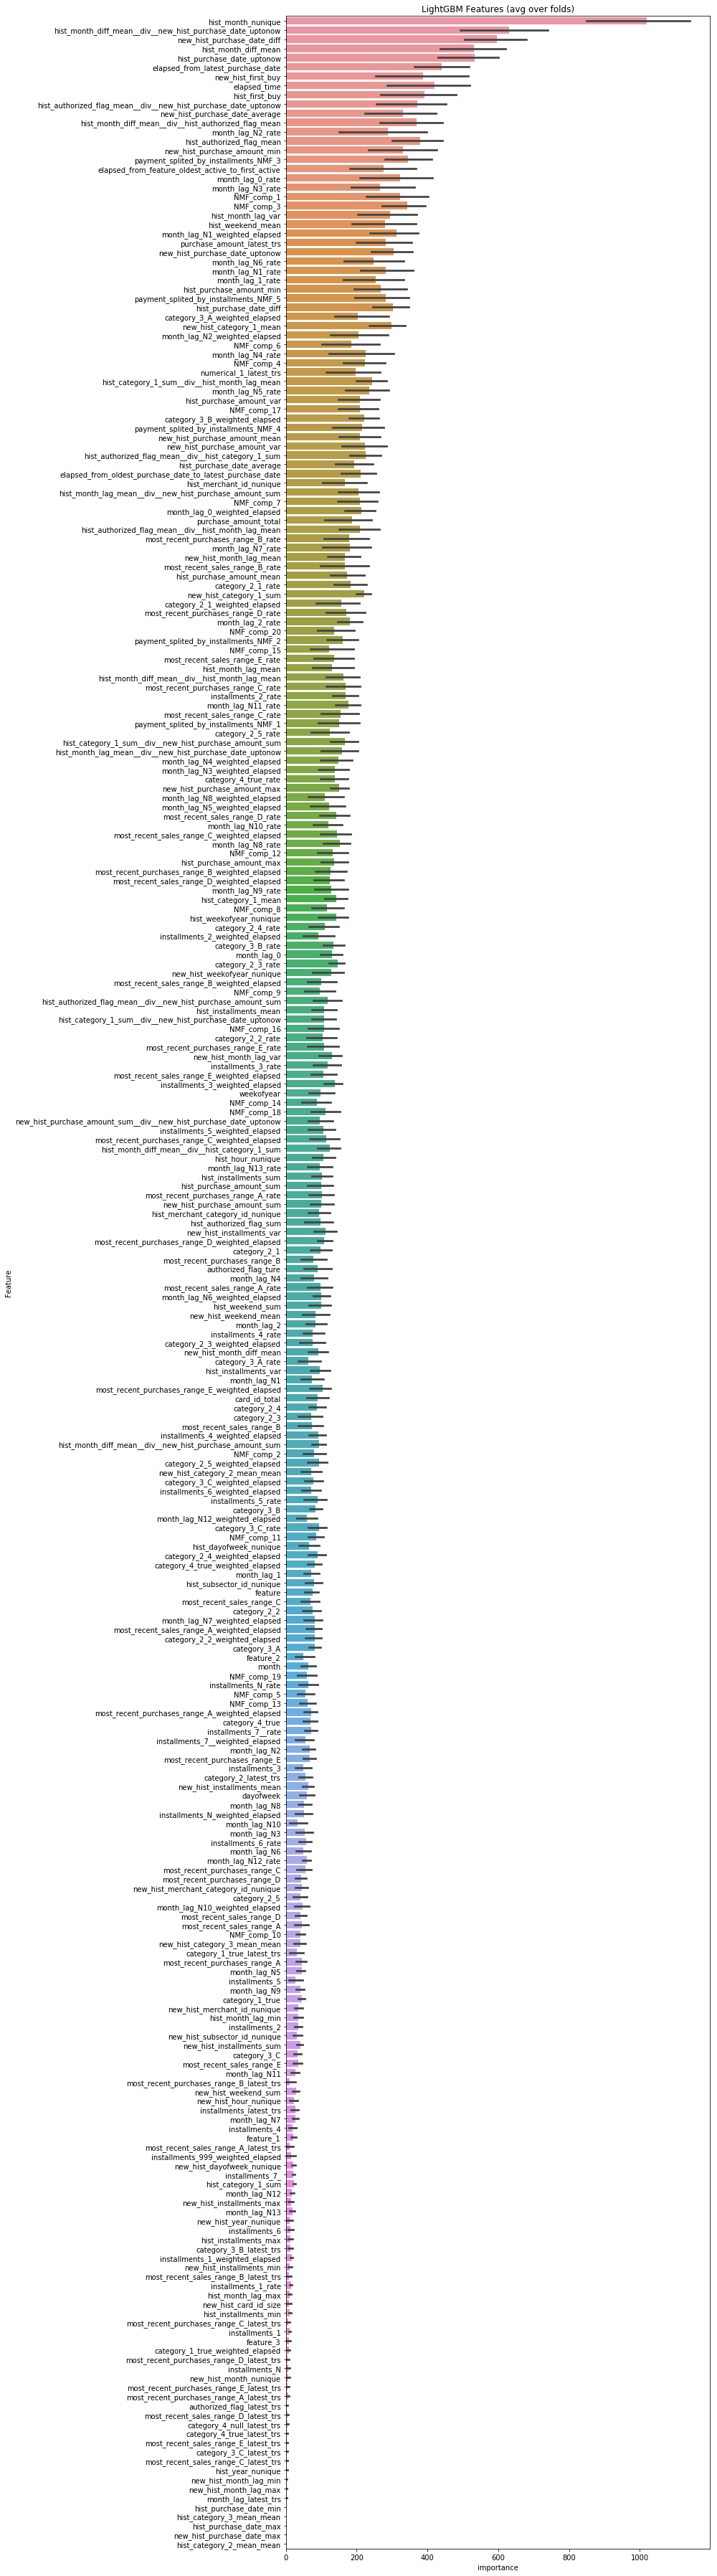

In [16]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [17]:
df_train_columns2 = cols[:200]

#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'binary',  #regression
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'auc',  #auc
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns2], label=target_outlier.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns2], label=target_outlier.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns2], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns2
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns2], num_iteration=clf.best_iteration) / folds.n_splits

roc_auc_score(target_outlier, oof)

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.909705	valid_1's auc: 0.896639
[200]	training's auc: 0.927758	valid_1's auc: 0.900973
[300]	training's auc: 0.938509	valid_1's auc: 0.904347
[400]	training's auc: 0.94822	valid_1's auc: 0.905231
[500]	training's auc: 0.956852	valid_1's auc: 0.90589
[600]	training's auc: 0.964299	valid_1's auc: 0.906294
[700]	training's auc: 0.96996	valid_1's auc: 0.905988
[800]	training's auc: 0.974233	valid_1's auc: 0.905341
[900]	training's auc: 0.977611	valid_1's auc: 0.904962
Early stopping, best iteration is:
[588]	training's auc: 0.963503	valid_1's auc: 0.906371
fold 1
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.912347	valid_1's auc: 0.882998
[200]	training's auc: 0.929535	valid_1's auc: 0.888472
[300]	training's auc: 0.939638	valid_1's auc: 0.891328
[400]	training's auc: 0.949864	valid_1's auc: 0.893956
[500]	training's auc: 0.957444	valid_1's auc: 0.895018
[60

0.9018406934731391

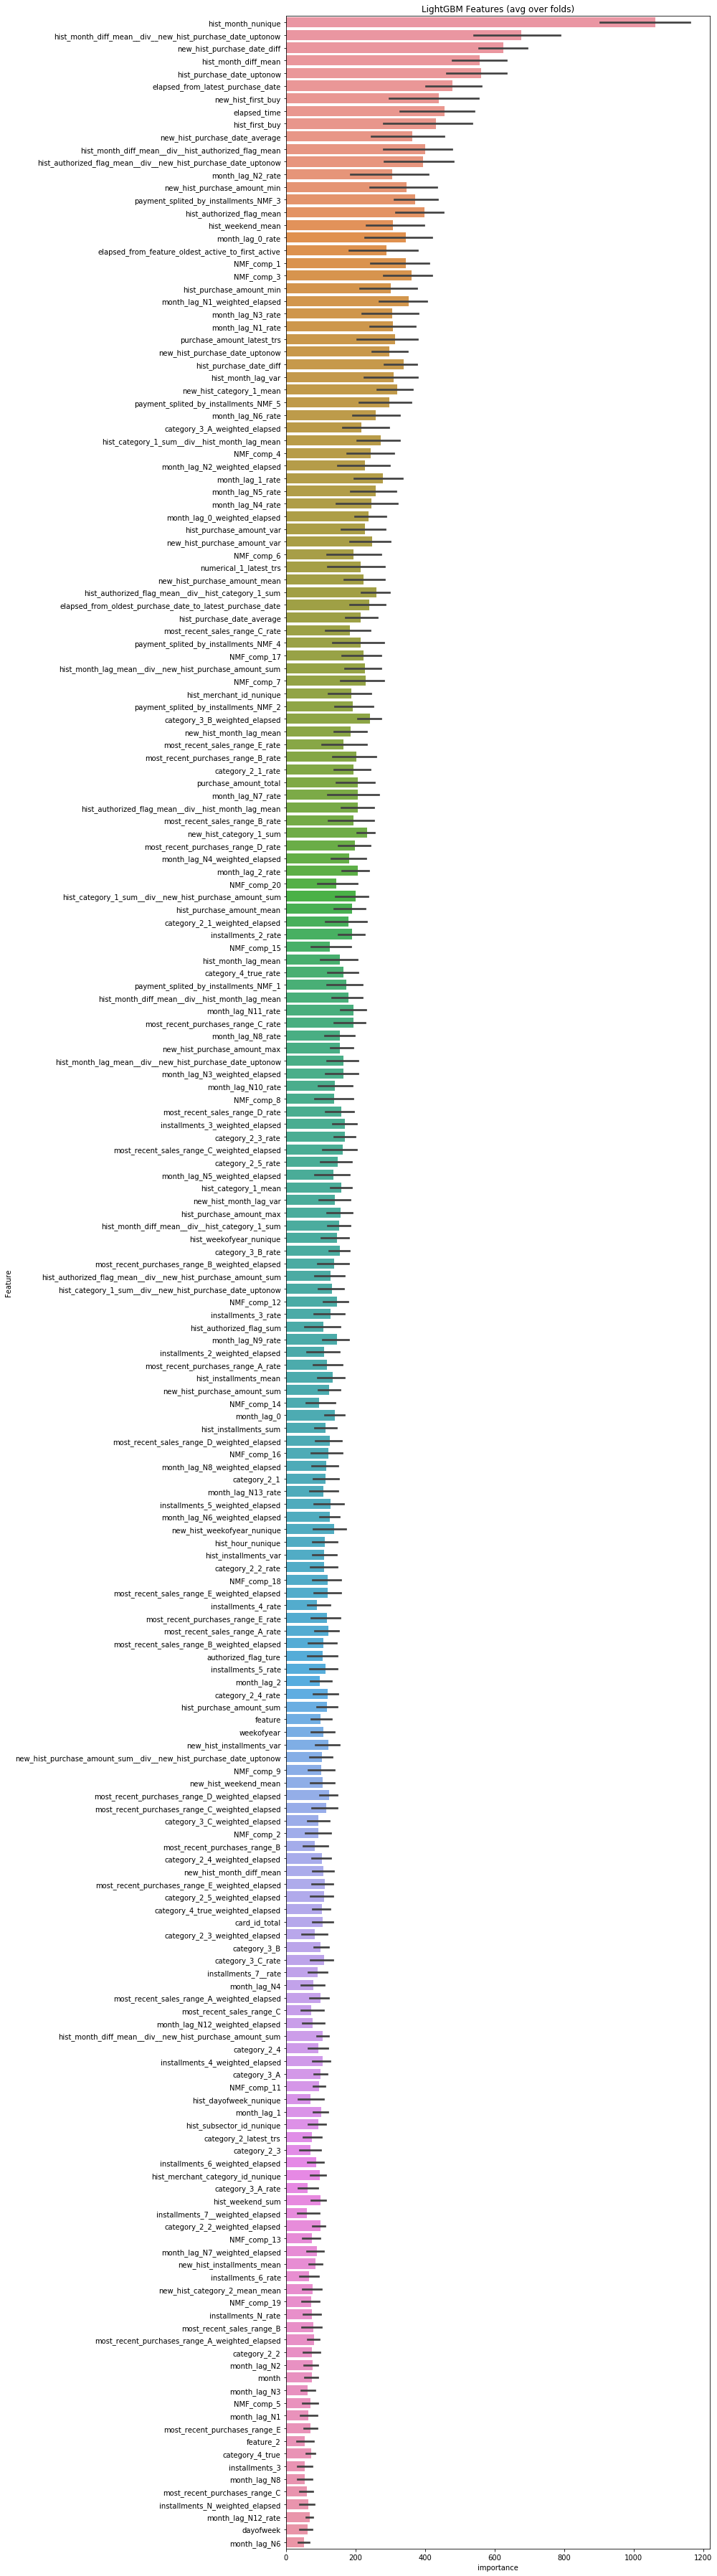

In [18]:
cols2 = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols2)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [19]:
for k in range(-30, 0, 1):
    rmse = []
    for i in [i/1000.0 for i in range(1,1001)]:
        predict_outliers = np.where(oof>i, k, 0)
        rmse.append(np.sqrt(mean_squared_error(target.values, predict_outliers)))
        if min(rmse) == rmse[-1]:
            best_th = i
    print("%d -- %f -- %f" %(k, min(rmse), best_th))

-30 -- 3.854462 -- 0.429000
-29 -- 3.853527 -- 0.429000
-28 -- 3.852694 -- 0.429000
-27 -- 3.851963 -- 0.429000
-26 -- 3.851150 -- 0.404000
-25 -- 3.850210 -- 0.404000
-24 -- 3.849406 -- 0.404000
-23 -- 3.847729 -- 0.280000
-22 -- 3.842024 -- 0.280000
-21 -- 3.836920 -- 0.280000
-20 -- 3.832421 -- 0.280000
-19 -- 3.828529 -- 0.280000
-18 -- 3.825245 -- 0.280000
-17 -- 3.820798 -- 0.233000
-16 -- 3.815320 -- 0.233000
-15 -- 3.809241 -- 0.196000
-14 -- 3.801400 -- 0.187000
-13 -- 3.794947 -- 0.187000
-12 -- 3.790248 -- 0.187000
-11 -- 3.787005 -- 0.181000
-10 -- 3.779932 -- 0.132000
-9 -- 3.774787 -- 0.115000
-8 -- 3.769117 -- 0.105000
-7 -- 3.766087 -- 0.089000
-6 -- 3.763560 -- 0.077000
-5 -- 3.763762 -- 0.070000
-4 -- 3.769149 -- 0.063000
-3 -- 3.773546 -- 0.035000
-2 -- 3.785651 -- 0.026000
-1 -- 3.815370 -- 0.018000


In [20]:
df_predict = pd.read_csv("../output/submission_model20181216.csv")
df_no_outliers_predict = pd.read_csv("../output/submission_no_outliers_model20190112.csv")

In [21]:
df_predict = pd.merge(df_predict, df_no_outliers_predict, on="card_id", how="inner")

In [22]:
df_predict["target"] = np.where(df_predict.target_x.values < 0, df_predict.target_x, df_predict.target_y)

del df_predict["target_x"]
del df_predict["target_y"]

df_predict

,card_id,target
0,C_ID_0ab67a22ab,-2.041275
1,C_ID_130fd0cbdd,-0.305701
2,C_ID_b709037bc5,-0.974894
3,C_ID_d27d835a9f,-0.090633
4,C_ID_2b5e3df5c2,-1.465622
5,C_ID_5814b4f13c,0.536912
6,C_ID_a1b3c75277,0.176816
7,C_ID_f7cada36d3,0.865616
8,C_ID_9d2bc8dfc4,-0.709276
9,C_ID_6d8dba8475,-1.145146


In [23]:
outliers_idx = np.where(predictions>0.404)[0]

In [24]:
outliers_idx.shape

(56,)

In [25]:
df_predict["target"].iloc[outliers_idx] = -25

In [26]:
df_predict[df_predict.target == -25]

,card_id,target
2624,C_ID_bd59e054f3,-25.0
5008,C_ID_be92f84f5c,-25.0
6026,C_ID_91cc0c06ca,-25.0
16074,C_ID_9c760806b5,-25.0
17778,C_ID_866eae8fb0,-25.0
18150,C_ID_ccf9ad6bf6,-25.0
18363,C_ID_d2871ae781,-25.0
20556,C_ID_aae50409e7,-25.0
23168,C_ID_3804897561,-25.0
26225,C_ID_44c140917d,-25.0


In [27]:
df_predict.target.describe()

count    123623.000000
mean         -0.338320
std           1.321524
min         -25.000000
25%          -0.654177
50%          -0.214578
75%           0.245338
max           5.014049
Name: target, dtype: float64

In [28]:
df_predict

,card_id,target
0,C_ID_0ab67a22ab,-2.041275
1,C_ID_130fd0cbdd,-0.305701
2,C_ID_b709037bc5,-0.974894
3,C_ID_d27d835a9f,-0.090633
4,C_ID_2b5e3df5c2,-1.465622
5,C_ID_5814b4f13c,0.536912
6,C_ID_a1b3c75277,0.176816
7,C_ID_f7cada36d3,0.865616
8,C_ID_9d2bc8dfc4,-0.709276
9,C_ID_6d8dba8475,-1.145146


In [29]:
df_predict[["card_id", "target"]].to_csv("../output/submission_model20190118.csv", index=False)